# Connectivity of ER Graphs

In the note [Graph-basics](http://nbviewer.jupyter.org/github/XiaoTaoWang/Think-Complexity-Notes/blob/master/notebooks/Graph-basics.ipynb), we introduced a classic random graph model named [Erdős–Rényi model](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model), and provided implementations of its two variants. Briefly, G(n,p) is characterized by two parameters, n is the number of nodes and p is the probability that there exists an edge linking any two nodes; G(n,m) also takes two parameters, in which a graph is chosen uniformly at random from the collection of all graphs which have n nodes and m edges.

Although closely related, G(n,p) is the more commonly used one in practice.

In a 1960 paper, Erdős and Rényi showed several interesting properties of G(n,p). One of their results is the existence of abrupt changes of graph connectivity(a graph is connected if there a path from any node to every other node) when increasing p. They showed that the critical p value is $\frac{ln(n)}{n}$, that is, ER graph is unlikely to be connected if $p < \frac{ln(n)}{n}$, but very likely to be connected if $p > \frac{ln(n)}{n}$. In this note, we will try to test this statement computationally.

## Platform Information

In [1]:
%load_ext watermark

In [2]:
%watermark -m -v -p numpy,networkx,matplotlib

CPython 2.7.12
IPython 5.1.0

numpy 1.11.1
networkx 1.11
matplotlib 1.5.3

compiler   : MSC v.1500 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 78 Stepping 3, GenuineIntel
CPU cores  : 4
interpreter: 64bit


## Connectivity

First of all, we need an algorithm to check whether a graph is connected. There are generally two search algorithms, [*BFS(breadth-first search)*](https://en.wikipedia.org/wiki/Breadth-first_search) and [*DFS(depth-first search)*](https://en.wikipedia.org/wiki/Depth-first_search), for determining whether two nodes in a graph are connected. These algorithms can be modified for our task in following way:
- Start with any node, s, in the graph.
- Use breadth-first search or depth-first search to count all nodes that can be reached from s.
- If the number of nodes counted is equal to the number of nodes in the graph, the graph is connected, otherwise, it is disconnected.

### Depth-first search

Allen provides an implementation of depth-first search in his book, here's the code with some modifications:

In [3]:
def DFS_nonrecursive(G, s):
    seen = set()
    stack = [s]
    while len(stack):
        c = stack.pop()
        if not c in seen:
            seen.add(c)
            stack.extend(G.neighbors(c))
    return seen

def is_connected(G):
    s = next(G.nodes_iter())
    reachable = DFS_nonrecursive(G, s)
    return len(reachable)==len(G)

*DFS_nonrecursive* use depth-first search to start with *s* and find all nodes in the graph reachable from *s*. *is_connected* chooses a starting node and invokes *DFS_nonrecursive*, if the length of *seen* returned by *DFS_nonrecursive* is the same as the size of the graph, that means we can reach all nodes, and then we can declare the graph is connected. Let's check it using a random graph:

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

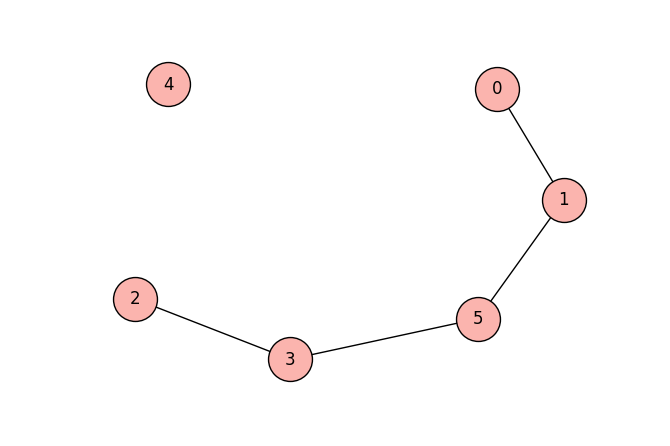

In [5]:
G = nx.gnp_random_graph(6, 0.2, seed=1)
nx.draw(G, node_color='#FBB4AE', node_size=1000, with_labels=True)
plt.show()

From node 0, all the other nodes except for node 4 can be reached:

In [6]:
seen = DFS_nonrecursive(G, 0)
print sorted(seen)

[0, 1, 2, 3, 5]


And the graph is indeed disconnected.

In [7]:
is_connected(G)

False

Why we call this kind of search as "depth-first"? Because it explores as far as possible before backtracking. In the view of programming, *DFS_nonrecursive* we defined just now uses a [*stack*](https://en.wikipedia.org/wiki/Stack_%28abstract_data_type%29) and gets the last added node in each loop.

Depth-first search can also be implemented in a quite more natural way using recursive function:

In [8]:
def DFS_recursive(G, s, seen):
    seen.add(s)
    for v in G.neighbors(s):
        if not v in seen:
            DFS_recursive(G, v, seen)
    return seen

def is_connected(G):
    s = next(G.nodes_iter())
    reachable = set()
    DFS_recursive(G, s, reachable)
    return len(reachable)==len(G)

In [9]:
seen = set()
DFS_recursive(G, 0, seen)
print sorted(seen)

[0, 1, 2, 3, 5]


In [10]:
is_connected(G)

False

### Breadth-first search

Different from depth-first search, breadth-first search starts at any node, and explores the neighbor nodes first, then the next level neighbors, and so forth. Here's my implementation:

In [11]:
from collections import deque

def BFS_search(G, s):
    
    Q = deque([s])
    seen = set([s])
    while len(Q):
        c = Q.popleft()
        for v in G.neighbors(c):
            if not v in seen:
                seen.add(v)
                Q.append(v)
    return seen

def is_connected(G):
    s = next(G.nodes_iter())
    reachable = BFS_search(G, s)
    return len(reachable)==len(G)

*BFS_search* and *DFS_nonrecursive* are very similar, but check them line by line, you'll find two differences:
- *BFS_search* use a *queue* instead of *stack*
- It checks whether a node has been added into *seen* before enqueueing the node rather than delaying this check until the node is dequeued from the queue.

In [12]:
seen = BFS_search(G, 0)
print sorted(seen)

[0, 1, 2, 3, 5]


In [13]:
is_connected(G)

False

### Benchmarks

In theory, the time complexities for *DFS_nonrecursive*, *DFS_recursive* and *BFS_search* are all in O(n+m), which means the run time grows in proportion to either n or m, whichever is "bigger". In this part, I'll check it computationally. Besides those functions we defined above, I will also include *networkx*'s builtin *is_connected* for benchmark.

To make the comparisons more elegant, let's modify the interface of *is_connected* a little:

In [14]:
def is_connected(G, core):
    s = next(G.nodes_iter())
    if core == DFS_recursive:
        reachable = set()
        DFS_recursive(G, s, reachable)
    else:
        reachable = BFS_search(G, s)
    return len(reachable)==len(G)

Generate complete graphs of various orders:

In [15]:
import numpy as np
orders_n = np.logspace(1.5, 2.5, 15).astype(int)
pool = [nx.complete_graph(n) for n in orders_n]
print orders_n

[ 31  37  43  51  61  71  84 100 117 138 163 193 227 268 316]


Since every node links any other node in a complete graph, *is_connected* should run in O($n^2$), and as we have discussed in the last note, if we plot t(time) versus n(number of nodes) on a log-log scale, we expect an approximate straight line with slope 2.

Plot runtime(t) along with the increasing numder of nodes:

In [16]:
import timeit

In [17]:
ours = {'DFS_nonrecursive':[], 'DFS_recursive':[], 'BFS_search':[]}
nx_t = []
for G in pool:
    T = timeit.Timer('is_connected(G)', 'from __main__ import G;from networkx import is_connected')
    nx_t.append(min(T.repeat(3,10))*1000) # 3 repeats, 10 loops
    for f in ours:
        T = timeit.Timer('is_connected(G, core=%s)' % f, 'from __main__ import is_connected, G, %s' % f)
        ours[f].append(min(T.repeat(3,10))*1000)

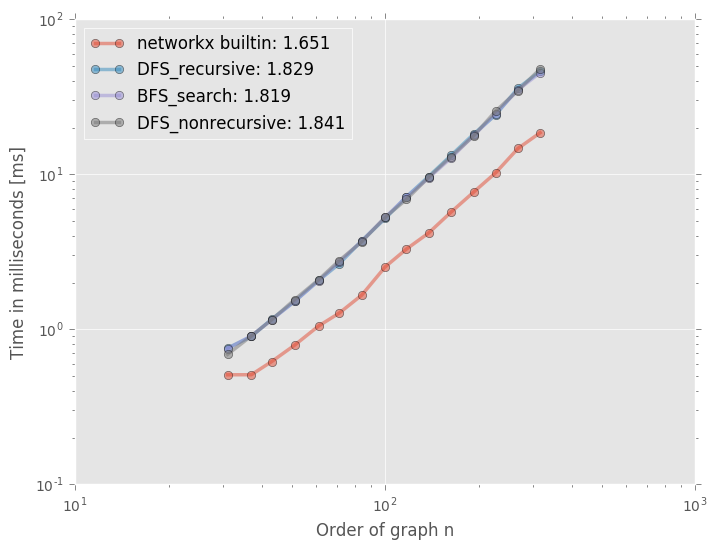

In [18]:
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
slope = np.polyfit(np.log10(orders_n), np.log10(nx_t), 1)[0]
plt.plot(orders_n, nx_t, alpha=0.5, label='networkx builtin: %.3f' % slope, marker='o', lw=2.5)
for f in ours:
    slope = np.polyfit(np.log10(orders_n), np.log10(ours[f]), 1)[0]
    mode = f + ': %.3f'
    plt.plot(orders_n, ours[f], alpha=0.5, label=mode % slope, marker='o', lw=2.5)
plt.xlabel('Order of graph n')
plt.ylabel('Time in milliseconds [ms]')
plt.legend(loc=2)
plt.xscale('log')
plt.yscale('log')
plt.show()

## The probability of connectivity

Now given certain *n* and *p* value, we are able to further estimate the probability that the G(n,p) is connected, simply by generating amounts of graphs and counting how many are connected.

In [19]:
def prob_connected(n, p, num=100):
    count = 0
    for i in xrange(num):
        G = nx.gnp_random_graph(n,p)
        if nx.is_connected(G):
            count += 1
    return count / float(num)

In [20]:
prob_connected(15, 0.4)

0.98

Then we need to estimate the probability for a range of *p* to get the view of the "transition":

In [21]:
n = [10, 30, 50, 100]
ps = np.logspace(-2, 0, 15)
probs = [[],[],[],[]]
for i in range(len(n)):
    for p in ps:
        probs[i].append(prob_connected(n[i], p))

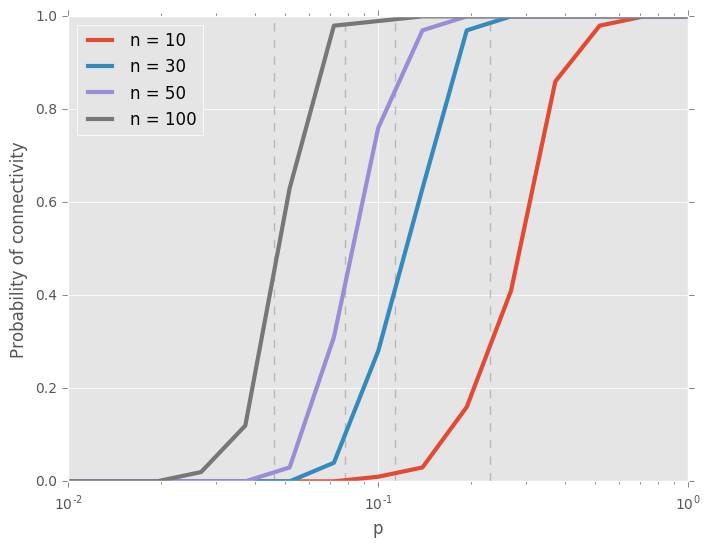

In [22]:
plt.figure(figsize=(8,6))
# Transition points
tps = [np.log(i)/i for i in n]
for i in range(len(n)):
    plt.plot(ps, probs[i], label='n = %d' % n[i], lw=3)
    plt.vlines([tps[i]], 0, 1, color='k', alpha=0.2, linestyle='--')
plt.xscale('log')
plt.legend(loc=2)
plt.xlabel('p')
plt.ylabel('Probability of connectivity')
plt.show()